# Importing Packages

Import packages

In [1]:
import pandas as pd
import numpy as np
import tqdm
import nltk
import time
import random
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from operator import itemgetter
from PIL import Image

In [2]:
import keras as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, recall_score, precision_score
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

%load_ext tensorboard

# Load Data and Preprocess

Load the messages

In [3]:
df = pd.read_csv('messages.csv')
df.head()
df_orig = df.copy()

In [4]:
df_orig.shape

(5572, 2)

In [5]:
pd.set_option('display.max_colwidth', None)

print(df_orig.head(5))

  Category  \
0      ham   
1      ham   
2     spam   
3      ham   
4      ham   

                                                                                                                                                       Message  
0                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  
3                                                                                                            U dun say so early hor... U c already then say...  
4                                                                                                Nah I don't t

In [6]:
df_orig.drop_duplicates(subset=['Message'], keep='first', inplace=True)

In [7]:
df_orig.shape

(5157, 2)

In [8]:
df_orig.value_counts('Category', normalize=True)

Category
ham     0.875703
spam    0.124297
dtype: float64

Create a binary target where 1 = Spam and 0 = Ham. Rename the columns.

In [9]:
df['target'] = [1 if x=='spam' else 0 for  x in df.Category]
df.drop('Category', axis=1, inplace=True)
df.columns = ['message','target']
df.drop_duplicates(subset=['message'], keep='first', inplace=True)
df_spam = df[df.target==1]
df_ham = df[df.target==0]

Observe the baseline accuracy

In [10]:
df.target.value_counts(normalize=True)

0    0.875703
1    0.124297
Name: target, dtype: float64

Baseline is 86.6%

Define X and y datasets, or predictors and target datasets.

In [11]:
X= df.message
y= df.target

I have left punctuation and non-alphanumeric characters in here for now because they are harmless. The Tensorflow Tokenizer can deal with them. 

# EDA Plots and Word Clouds

## EDA Plots

In [12]:
df_orig['word_count'] = df_orig.Message.apply(lambda x: len(x.split(' ')))

In [13]:
df_orig.groupby('Category')['word_count'].agg(['count','mean','median'])

,count,mean,median
Category,,,
ham,4516,14.328388,11.0
spam,641,23.659906,25.0


In [14]:
df_orig.sample(5)

,Category,Message,word_count
2965,spam,"Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?",25
5411,ham,I ask if u meeting da ge tmr nite...,9
471,spam,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm,27
204,ham,Goodmorning sleeping ga.,3
2586,ham,I will be outside office take all from there,9


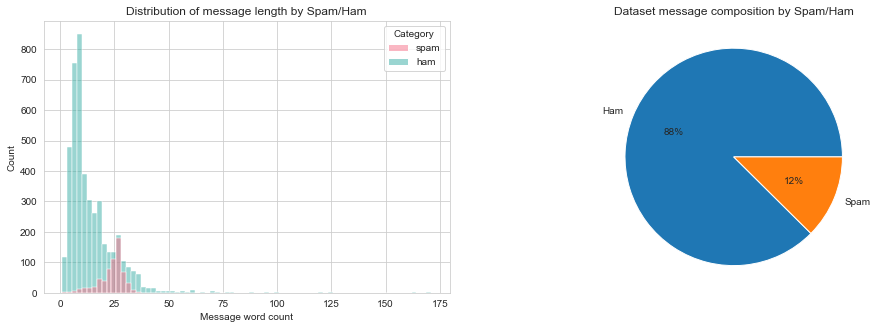

In [15]:
# Plot message length by spam/ham

df_orig['Category'] = pd.Categorical(df_orig['Category'], ['spam','ham'])
sns.set_style("whitegrid")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
sns.histplot(data=df_orig, 
             x="word_count",
             hue="Category",
             palette='husl',
             bins=75,
             ax=ax[0],
             legend=True).set_title('Distribution of message length by Spam/Ham')
ax[0].set_xlabel('Message word count')
ax[0].set_ylabel('Count')
colors = sns.color_palette('husl')

ax[1].pie(df_orig.Category.value_counts(normalize=True), labels = ['Ham','Spam'], autopct='%0.f%%')
ax[1].set_title('Dataset message composition by Spam/Ham')
plt.savefig('images/eda.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [16]:
df_orig.sort_values(by='word_count', ascending=False)

,Category,Message,word_count
1085,ham,For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..,171
1863,ham,"The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed.",162
2158,ham,"Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents forgot n so did my Kids . I went to work. Even my Colleagues did not wish. As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there. She said,'' do u mind if I go into the bedroom for a minute ? '' ''OK'', I sed in a sexy mood. She came out 5 minuts latr wid a cake...n My Wife, My Parents, My Kidz, My Friends n My Colleagues. All screaming.. SURPRISE !! and I was waiting on the sofa.. ... ..... ' NAKED...!",125
1579,ham,How to Make a girl Happy? It's not at all difficult to make girls happy. U only need to be... 1. A friend 2. Companion 3. Lover 4. Chef . . . &lt;#&gt; . Good listener &lt;#&gt; . Organizer &lt;#&gt; . Good boyfriend &lt;#&gt; . Very clean &lt;#&gt; . Sympathetic &lt;#&gt; . Athletic &lt;#&gt; . Warm . . . &lt;#&gt; . Courageous &lt;#&gt; . Determined &lt;#&gt; . True &lt;#&gt; . Dependable &lt;#&gt; . Intelligent . . . &lt;#&gt; . Psychologist &lt;#&gt; . Pest exterminator &lt;#&gt; . Psychiatrist &lt;#&gt; . Healer . . &lt;#&gt; . Stylist &lt;#&gt; . Driver . . Aaniye pudunga venaam..,121
2434,ham,"Indians r poor but India is not a poor country. Says one of the swiss bank directors. He says that "" &lt;#&gt; lac crore"" of Indian money is deposited in swiss banks which can be used for 'taxless' budget for &lt;#&gt; yrs. Can give &lt;#&gt; crore jobs to all Indians. From any village to Delhi 4 lane roads. Forever free power suply to more than &lt;#&gt; social projects. Every citizen can get monthly &lt;#&gt; /- for &lt;#&gt; yrs. No need of World Bank &amp; IMF loan. Think how our money is blocked by rich politicians. We have full rights against corrupt politicians. Itna forward karo ki pura INDIA padhe.g.m.""",119
...,...,...,...
284,ham,Okie...,1
2908,ham,ALRITE,1
2508,ham,Yup...,1
783,ham,Beerage?,1


## Word Clouds

In [17]:
# count word appearances
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

# sort words by frequency
def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True)
    return sort_result

In [18]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Series text column
tvec = TfidfVectorizer(stop_words = stop,
                       ngram_range = (1, 2),
                       max_features = 1000,
                       token_pattern = '[A-Za-z0-9]+(?=\\s+)',
                        )

# Fit vectorizer on text data
tvec.fit(df.message)

# Transform data
tvec_mat = tvec.transform(df.message)

# words occuring
words = tvec.get_feature_names_out()

# count word appearances
csum= word_counter(tvec_mat)

In [19]:
# sort words by frequency
df_word_frequency = pd.DataFrame(word_frequency_sorter(
    words, csum), columns=["word", "frequency_series"])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.index.name = None
df_word_frequency.head(20)

,frequency_series
u,187.755719
call,109.487576
get,108.333458
2,91.910420
ur,81.290887
got,78.853555
like,78.550733
come,77.469296
go,74.703036
know,68.392965


In [20]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)

# create word cloud
wc_all = WordCloud(stopwords=stopwords,
                                  max_words=200,
                                  background_color="white")

# generate a word cloud image
wc_all.generate(wrds_cnt)

There are 413095 unique words in all the descriptions.


In [21]:
# ham description text
wrds_cnt = " ".join(wrds for wrds in df_ham.message)
print ("There are {} unique words in ham the descriptions.".format(len(wrds_cnt)))

# create word mask
mask_ham = np.array(Image.open('images/ham2.png'))

# create word cloud
wc_ham = WordCloud(stopwords=STOPWORDS,
               mask=mask_ham, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask_ham.shape[1],
               height=mask_ham.shape[0])
wc_ham.generate(wrds_cnt);

There are 324561 unique words in ham the descriptions.


In [22]:
# spam description text
wrds_cnt = " ".join(wrds for wrds in df_spam.message)
print ("There are {} unique words in spam the descriptions.".format(len(wrds_cnt)))

# create word mask
mask_spam = np.array(Image.open('images/spam2.png'))

# create word cloud
wc_spam = WordCloud(stopwords=STOPWORDS,
               mask=mask_spam, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask_spam.shape[1],
               height=mask_spam.shape[0])
wc_spam.generate(wrds_cnt);

There are 88533 unique words in spam the descriptions.


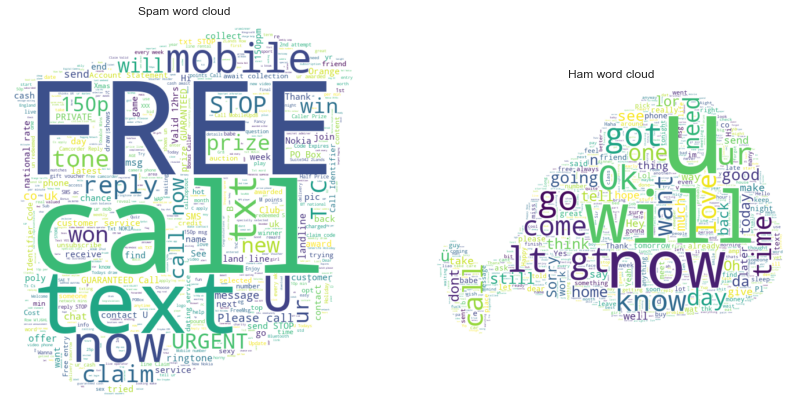

In [23]:
# combine wordcloud plots
sns.set_style("white")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
ax[0].imshow(wc_spam, interpolation="bilinear")
ax[0].set_title('Spam word cloud')
ax[1].imshow(wc_ham, interpolation="bilinear")
ax[1].set_title('Ham word cloud')
fig.set_facecolor("white")
ax[0].axis('off')
ax[1].axis('off')
plt.savefig('images/cloud.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

# Tensorflow Modelling

In [24]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [25]:
SEQUENCE_LENGTH = 50 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 100  # Using 100-Dimensional GloVe embedding vectors
TEST_SIZE = 0.25 # ratio of testing set

BATCH_SIZE = 64
EPOCHS = 20 # number of epochs

## Tokenize

In [26]:
# Text tokenization - we have to do this before obtaining the word embeddings 
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# vectorizing text, turning each text into sequence of integers. 
# Default behaviour is to filter all punctuation, plus tabs and line breaks, minus the ' character.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

# Save this dictionary for later
word_index = tokenizer.word_index

In [27]:
print(X[1])

[49, 304, 1364, 435, 6, 1766]


In [28]:
# pad sequences at the beginning of each sequence with 0's
# for example if SEQUENCE_LENGTH=4:
# [[5, 3, 2], [5, 1, 2, 3], [3, 4]]
# will be transformed to:
# [[0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4]]
X = pad_sequences(sequences=X, 
                  maxlen=SEQUENCE_LENGTH, 
                  padding='pre', 
                  truncating='post')

In [29]:
print(X.shape)

(5157, 50)


Discuss what this 100 term is

In [30]:
X

array([[   0,    0,    0, ...,   56, 4005,  137],
       [   0,    0,    0, ...,  435,    6, 1766],
       [   0,    0,    0, ...,  707,  437, 4006],
       ...,
       [   0,    0,    0, ...,  100,  240, 9003],
       [   0,    0,    0, ...,  192,   12,   53],
       [   0,    0,    0, ...,    2,   63,  284]], dtype=int32)

In [31]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: target, Length: 5157, dtype: int64

## Train-Test Split

In [32]:
# split and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=5)
# print our data shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (3867, 50)
X_test.shape: (1290, 50)
y_train.shape: (3867,)
y_test.shape: (1290,)


## Word Embedding Using GloVe

I'm using a pre-trained [GloVe word embedding](https://nlp.stanford.edu/projects/glove/) dataset in 100 dimensional space, saved outside of this repository. 

This function opens the GloVe file and maps each of the tokenized words to the corresponding embedded vector. This process works to encode meanings of words in a way that causes words of comparable meaning to be expressed similarly in the defined vector space. More can be read about word embedding [here](https://machinelearningmastery.com/what-are-word-embeddings/).

In [33]:
# https://machinelearningmastery.com/what-are-word-embeddings/
# https://nlp.stanford.edu/projects/glove/

def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    with open(f"../data/glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

## BiLSTM Model Definition

Define a list of metrics to be used later in the model definition. These will be calculated and saved after each epoch in the model build for visibility on the modelling process.

In [34]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve

2022-03-29 17:21:33.894996: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now to define the Keras model. I'm going to do this using the [sequential model API](https://machinelearningmastery.com/keras-functional-api-deep-learning/) where Sequential class is created and model layers are then added to it. The steps I use are as follows:
* Embed the tokenized words
* Add a user defined number of Bi-directional Long Short-Term Memory units 
* Add a Dropout feature of 0.2 to combat over-fitting
* Output one dense layer with a sigmoid activation function for 1/0 classification
* Compile the model using [binary crossentropy](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/) as the loss function and rmsprop optimizer, reporting the extensive list of metrics after each epoch 

With training the model through back-propagation, RNNs famously suffer from the vanishing gradient problem. This means that the RNN would struggle to learn long-range dependencies from the early layers and is often described as a short-term memory problem. To combat this we used specialised units within the hidden layers - Long Short-Term Memory units or LSTMs. These LSTMs are able to learn long-range dependencies through a series of gated tensor operations which dictate what information to add or remove from the hidden state at each unit. 
<br>
<br>
<img src="images/LSTM.png" width=400 height=400 />
<center><sub>This is a graphical representation of a single LSTM unit. The sigma and tanh cells represent sigmoid and hyperbolic tangent functions respectively. X_t and h_t are the input vector and output value of the LSTM unit. </sub></center>

In [35]:
def get_bidirectional_model(tokenizer, lstm_units):
    """
    Constructs the model,
    Embedding vectors => Bi-LSTM => 1 output Fully-Connected neuron with sigmoid activation
    """
    # get the GloVe embedding vectors
    embedding_matrix = get_embedding_vectors(tokenizer)
    # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
    model = Sequential()
    # First, embed the words using loaded GloVe
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=True,
              mask_zero=True,
              input_length=SEQUENCE_LENGTH))
    # Add bidirectional long short-term memory units
    model.add(Bidirectional(LSTM(lstm_units, recurrent_dropout=0.2)))
    # Add dropout to combat overfitting
    model.add(Dropout(0.2))
    # Add output dense layer with sigmoid for 1/0 classification
    model.add(Dense(1, activation="sigmoid"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", 
                  loss="binary_crossentropy",
                  metrics=[METRICS])

    model.summary()
    return model

Call the `get_model` function to generate the skeleton - not trained yet.

In [36]:
# constructs the bidirectional-model with 128 LSTM units
bimodel = get_bidirectional_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400001it [00:08, 48521.10it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           900500    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,135,253
Trainable params: 1,135,253
Non-trainable params: 0
_________________________________________________________________


Initialise required TensorBoard callbacks, best model_checkpoints and early stopping. Then fit the model using a batch size and number of epochs defined at the start of section 3. 

[Intersting link on explaining feature importance, although I don't know how it will work with the word embedder](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models)

## BiLSTM Model Training

In [37]:
# initialize our ModelCheckpoint and TensorBoard callbacks
# model checkpoint for saving best weights
model_checkpoint = ModelCheckpoint("../results/spam_classifier_{val_loss:.2f}.h5", save_best_only=True,
                                    verbose=1)
# for better visualization
tensorboard = TensorBoard(log_dir=f"logs/spam_classifier_{time.time()}", histogram_freq=1)
%tensorboard --logdir ./logs

# define model stopping criteria
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                              restore_best_weights=True)
# train the model
history = bimodel.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=BATCH_SIZE, #64
          epochs=EPOCHS, #20
          callbacks=[tensorboard, model_checkpoint, early_stop],
          verbose=1)
%tensorboard --logdir logs/fit

# My tensorboard source https://www.youtube.com/watch?v=-9-Hy5dWKLE

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Epoch 1/20
61/61 [==============================] - ETA: 0s - loss: 0.1601 - tp: 322.0000 - fp: 52.0000 - tn: 3330.0000 - fn: 163.0000 - accuracy: 0.9444 - precision: 0.8610 - recall: 0.6639 - auc: 0.9509 - prc: 0.8381
Epoch 1: val_loss improved from inf to 0.07070, saving model to ../results/spam_classifier_0.07.h5
61/61 [==============================] - 15s 159ms/step - loss: 0.1601 - tp: 322.0000 - fp: 52.0000 - tn: 3330.0000 - fn: 163.0000 - accuracy: 0.9444 - precision: 0.8610 - recall: 0.6639 - auc: 0.9509 - prc: 0.8381 - val_loss: 0.0707 - val_tp: 137.0000 - val_fp: 9.0000 - val_tn: 1125.0000 - val_fn: 19.0000 - val_accuracy: 0.9783 - val_precision: 0.9384 - val_recall: 0.8782 - val_auc: 0.9828 - val_prc: 0.9577
Epoch 2/20
61/61 [==============================] - ETA: 0s - loss: 0.0710 - tp: 426.0000 - fp: 29.0000 - tn: 3353.0000 - fn: 59.0000 - accuracy: 0.9772 - precision: 0.9363 - recall: 0.8784 - auc: 0.9873 - prc: 0.9602
Epoch 2: val_loss improved from 0.07070 to 0.06883, 

Epoch 13/20
61/61 [==============================] - ETA: 0s - loss: 0.0017 - tp: 484.0000 - fp: 1.0000 - tn: 3381.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - prc: 1.0000
Epoch 13: val_loss did not improve from 0.04715
61/61 [==============================] - 9s 141ms/step - loss: 0.0017 - tp: 484.0000 - fp: 1.0000 - tn: 3381.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0643 - val_tp: 143.0000 - val_fp: 4.0000 - val_tn: 1130.0000 - val_fn: 13.0000 - val_accuracy: 0.9868 - val_precision: 0.9728 - val_recall: 0.9167 - val_auc: 0.9797 - val_prc: 0.9629
Epoch 14/20
61/61 [==============================] - ETA: 0s - loss: 5.3643e-04 - tp: 485.0000 - fp: 0.0000e+00 - tn: 3382.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 14: val_loss did not improve from 0.04715
61/61 [==============================] - 8s 129ms/

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# Model Scoring

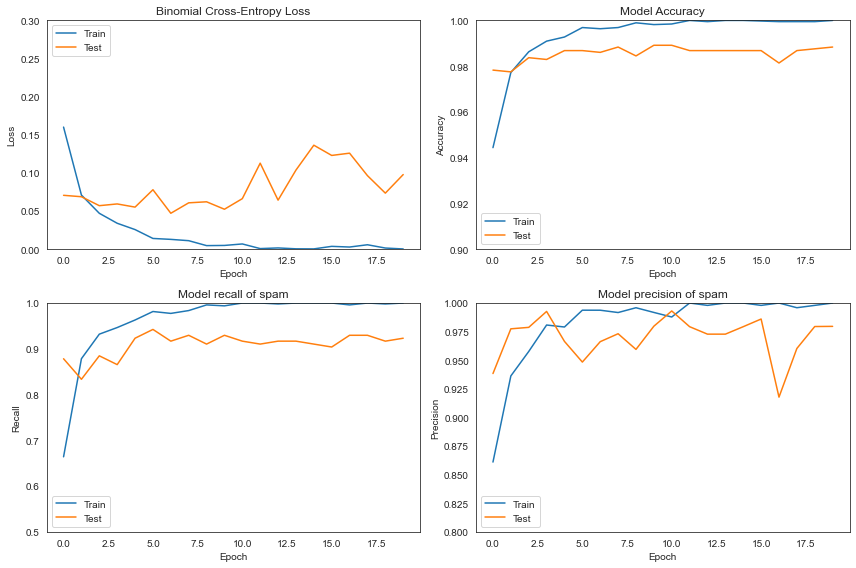

In [38]:
# Plot classification model performance metrics

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0].plot(history.history['loss'], label='Train')
ax[0,0].plot(history.history['val_loss'], label='Test')
ax[0,0].set_title('Binomial Cross-Entropy Loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_ylim(0,0.3)
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(loc='upper left')
ax[0,1].plot(history.history['accuracy'], label='Train')
ax[0,1].plot(history.history['val_accuracy'], label='Test')
ax[0,1].set_title('Model Accuracy')
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.9,1)
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(loc='lower left')
ax[1,0].plot(history.history['recall'], label='Train')
ax[1,0].plot(history.history['val_recall'], label='Test')
ax[1,0].set_title('Model recall of spam')
ax[1,0].set_ylabel('Recall')
ax[1,0].set_ylim(0.5,1)
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(loc='lower left')
ax[1,1].plot(history.history['precision'], label='Train')
ax[1,1].plot(history.history['val_precision'], label='Test')
ax[1,1].set_title('Model precision of spam')
ax[1,1].set_ylabel('Precision')
ax[1,1].set_ylim(0.8,1)
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(loc='lower left')
plt.tight_layout()
plt.savefig('images/progression.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

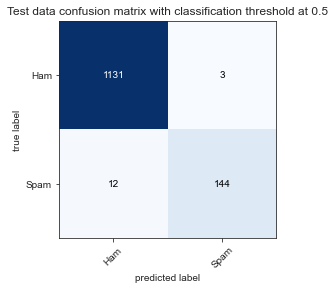

In [39]:
# Confusion matrix
y_pred = (bimodel.predict(X_test) > 0.5).astype("int32")

plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam'])
plt.title('Test data confusion matrix with classification threshold at 0.5')
plt.savefig('images/confusion50.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [40]:
# get the loss and metrics
result = bimodel.evaluate(X_test, y_test)
# extract those
loss = result[0]
accuracy = result[5]
precision = result[6]
recall = result[7]
f1 = (2*precision*recall)/(precision+recall)

print(f"Accuracy:    {accuracy*100:.2f}%")
print(f"Precision:   {precision*100:.2f}%")
print(f"Recall:      {recall*100:.2f}%")
print(f"F1 Score:    {f1*100:.2f}%")

41/41 [==============================] - 1s 15ms/step - loss: 0.0979 - tp: 144.0000 - fp: 3.0000 - tn: 1131.0000 - fn: 12.0000 - accuracy: 0.9884 - precision: 0.9796 - recall: 0.9231 - auc: 0.9764 - prc: 0.9535
Accuracy:    98.84%
Precision:   97.96%
Recall:      92.31%
F1 Score:    95.05%


In [41]:
# Sklearn metrics
probs = list(bimodel.predict(X_test))
outcome = [0 if x[0]<0.5 else 1 for x in list(probs)]
dfpred = pd.DataFrame({'true': y_test,'pred':outcome})

print(confusion_matrix(dfpred.true, dfpred.pred))
print(f'Accuracy   {accuracy_score(dfpred.true, dfpred.pred)*100:.2f}%')
print(f'Precision  {precision_score(dfpred.true, dfpred.pred)*100:.2f}%')
print(f'Recall     {recall_score(dfpred.true, dfpred.pred)*100:.2f}%')
print(f'F1-score   {f1_score(dfpred.true, dfpred.pred)*100:.2f}%')

[[1131    3]
 [  12  144]]
Accuracy   98.84%
Precision  97.96%
Recall     92.31%
F1-score   95.05%


In [42]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    # get the prediction
    prediction = bimodel.predict(sequence)
    if prediction >0.5:
        return 'Spam'
    else:
        return 'Ham'

In [43]:
# Spam test
text = "Final Chance! Claim ur £150 worth of discount vouchers today! "
print(get_predictions(text))

Spam


In [44]:
# Ham test
text = "Hi man, I was wondering if we can meet tomorrow."
print(get_predictions(text))

Ham


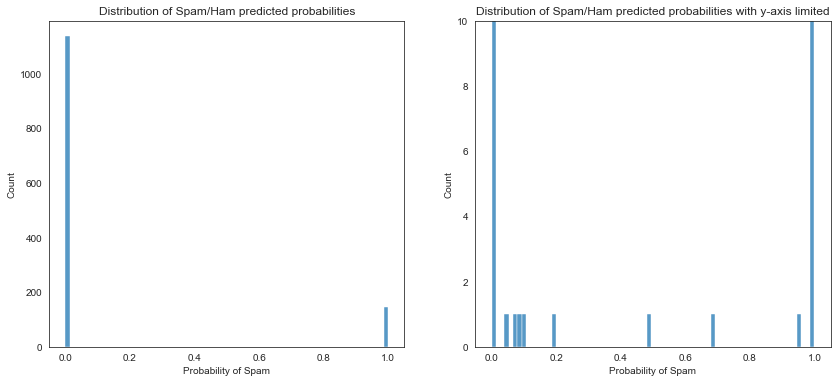

In [45]:
# Distribution plots of spam probabilities from bimodel

probs_spam = list(bimodel.predict(X_test))
probs_spam

Y_pp = pd.DataFrame(probs_spam, columns=['prob_spam'])
Y_pp['prob_ham']=Y_pp.prob_spam.apply(lambda x: 1-x)


fig, ax = plt.subplots(ncols=2, figsize=(14,6))
sns.histplot(data=Y_pp, 
             x="prob_spam",
             palette='husl',
             bins=75,
             ax=ax[1],
             legend=True).set_title('Distribution of Spam/Ham predicted probabilities with y-axis limited')
sns.histplot(data=Y_pp, 
             x="prob_spam",
             palette='husl',
             bins=75,
             ax=ax[0],
             legend=True).set_title('Distribution of Spam/Ham predicted probabilities')
ax[1].set_ylim(0,10)
ax[0].set_xlabel('Probability of Spam')
ax[1].set_xlabel('Probability of Spam')
plt.savefig('images/prob_dist.png',bbox_inches='tight',dpi=400, pad_inches=0.1)

plt.show()

In [46]:
Y_pp

,prob_spam,prob_ham
0,1.899212e-06,0.999998
1,2.168372e-09,1.000000
2,6.188382e-08,1.000000
3,9.566612e-09,1.000000
4,1.887944e-08,1.000000
...,...,...
1285,2.169811e-09,1.000000
1286,1.000000e+00,0.000000
1287,8.736322e-07,0.999999
1288,2.422741e-10,1.000000


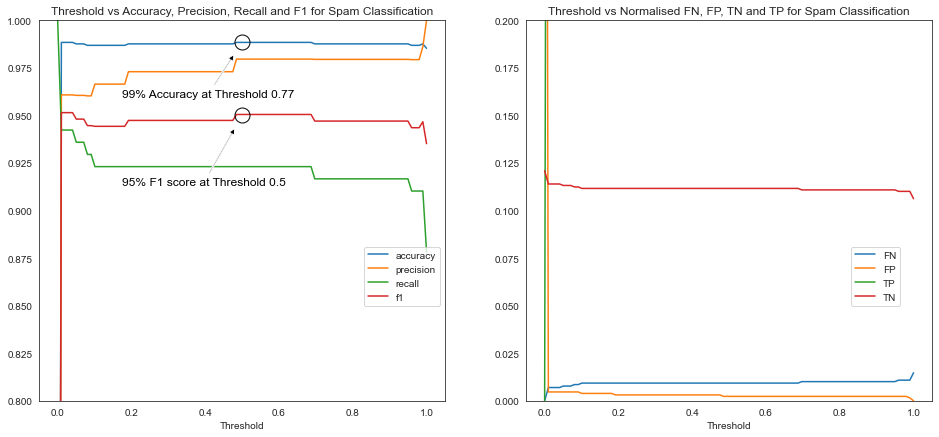

In [60]:
# Define some functions to help, then plot different scores at different thresholds
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

def scores_at_thresholds(probs, test_data):
    predictions = [probs.apply(predict_at_threshold, threshold=i) for i in np.linspace(0, 1, 100)]
    scores = np.array(
    [(threshold, 
      accuracy_score(test_data, predictions[i]),
      precision_score(test_data, predictions[i],zero_division=1),
      recall_score(test_data, predictions[i]), 
      f1_score(test_data, predictions[i]),
      confusion_matrix(test_data,predictions[i], normalize='all')[1,0],
      confusion_matrix(test_data,predictions[i], normalize='all')[0,1],
      confusion_matrix(test_data,predictions[i], normalize='all')[0,0],
      confusion_matrix(test_data,predictions[i], normalize='all')[1,1]) 
      
     for i, threshold in enumerate(np.linspace(0, 1, 100))])
    return scores


scores = scores_at_thresholds(Y_pp.prob_spam, y_test);

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,7))

# Plot data
ax1.plot(scores[:, 0], scores[:, 1], label='accuracy')
ax1.plot(scores[:, 0], scores[:, 2], label='precision')
ax1.plot(scores[:, 0], scores[:, 3], label='recall')
ax1.plot(scores[:, 0], scores[:, 4], label='f1')
ax2.plot(scores[:, 0], scores[:, 5], label='FN')
ax2.plot(scores[:, 0], scores[:, 6], label='FP')
ax2.plot(scores[:, 0], scores[:, 7], label='TP')
ax2.plot(scores[:, 0], scores[:, 8], label='TN')

# Adjust legends, titles and labels
ax1.legend(loc=[0.8, 0.25])
ax1.set_xlabel('Threshold')
ax1.set_title('Threshold vs Accuracy, Precision, Recall and F1 for Spam Classification')
ax1.set_ylim(0.8,1)

ax2.legend(loc=[0.8, 0.25])
ax2.set_xlabel('Threshold')
ax2.set_title('Threshold vs Normalised FN, FP, TN and TP for Spam Classification')
ax2.set_ylim(0.0,0.2)

# Annotations
circle_rad = 15  # This is the radius, in points
point=[0.5,0.9885]
ax1.plot(point[0], point[1], 'o', ms=circle_rad * 1, mec='black', mfc='none', mew=1)
ax1.annotate('99% Accuracy at Threshold 0.77', xy=point, xytext=(-120, -55),
            textcoords='offset points',
            color='black', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.1,head_width=0.5,head_length=0.5',
                facecolor='black', shrinkB=circle_rad * 1))

point=[0.5,0.95]
ax1.plot(point[0], point[1], 'o', ms=circle_rad * 1, mec='black', mfc='none', mew=1)
ax1.annotate('95% F1 score at Threshold 0.5', xy=point, xytext=(-120, -70),
            textcoords='offset points',
            color='black', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.1,head_width=0.5,head_length=0.5',
                facecolor='black', shrinkB=circle_rad * 1))

# point=[0.78,0.025]
# ax2.plot(point[0], point[1], 'o', ms=circle_rad * 1, mec='black', mfc='none', mew=1)
# ax2.annotate('FP=2.5% at Threshold 0.78', xy=point, xytext=(-90, 60),
#             textcoords='offset points',
#             color='black', size='large',
#             arrowprops=dict(
#                 arrowstyle='simple,tail_width=0.1,head_width=0.5,head_length=0.5',
#                 facecolor='black', shrinkB=circle_rad * 1))
plt.savefig('images/threshold.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show();

In [48]:
Y_pp['pred_class_thresh'] = Y_pp.prob_spam.apply(predict_at_threshold, 
                                                threshold=0.5)
print(classification_report(y_test, Y_pp.pred_class_thresh))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1134
           1       0.98      0.92      0.95       156

    accuracy                           0.99      1290
   macro avg       0.98      0.96      0.97      1290
weighted avg       0.99      0.99      0.99      1290



In [49]:
Y_pp['pred_class_thresh'] = Y_pp.prob_spam.apply(predict_at_threshold, 
                                                threshold=0.77)
print(classification_report(y_test, Y_pp.pred_class_thresh))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1134
           1       0.98      0.92      0.95       156

    accuracy                           0.99      1290
   macro avg       0.98      0.96      0.97      1290
weighted avg       0.99      0.99      0.99      1290



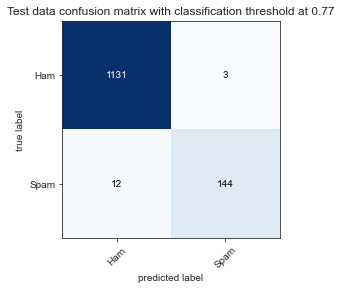

In [58]:
# Confusion matrix
y_pred = (bimodel.predict(X_test) > 0.5).astype("int32")

plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam'])
plt.title('Test data confusion matrix with classification threshold at 0.77')
plt.savefig('images/confusion77.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [51]:
# Sklearn metrics
probs = list(bimodel.predict(X_test))
outcome = [0 if x[0]<0.77 else 1 for x in list(probs)]
dfpred = pd.DataFrame({'true': y_test,'pred':outcome})

print(confusion_matrix(dfpred.true, dfpred.pred))
print(f'Accuracy   {accuracy_score(dfpred.true, dfpred.pred)*100:.2f}%')
print(f'Precision  {precision_score(dfpred.true, dfpred.pred)*100:.2f}%')
print(f'Recall     {recall_score(dfpred.true, dfpred.pred)*100:.2f}%')
print(f'F1-score   {f1_score(dfpred.true, dfpred.pred)*100:.2f}%')

[[1131    3]
 [  13  143]]
Accuracy   98.76%
Precision  97.95%
Recall     91.67%
F1-score   94.70%
